In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
import pickle

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

Email [me](mailto:totrash@duck.com) to get access to the dataset 

## Load Alert Data

In [2]:
alert_data = pd.read_csv(
    "dataset/alert.csv", 
    index_col=0, 
    encoding="utf-8"
)
alert_data.shape

(489850, 15)

In [3]:
netflow_fields = pd.read_csv("dataset/netflow/netflow-feats.csv").columns

flows_list = os.listdir("dataset/netflow/flow")
np.random.shuffle(flows_list)

## Freq of uniq signatures

In [3]:
alert_data.sig_id.unique().shape[0]

198

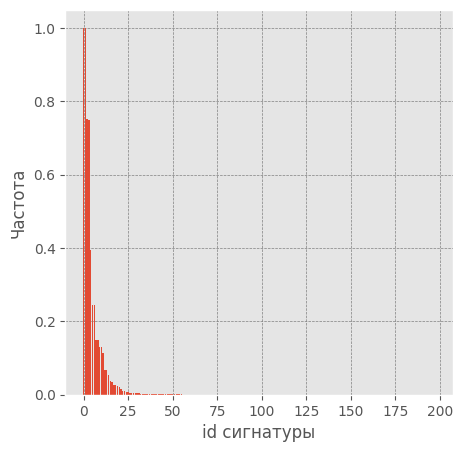

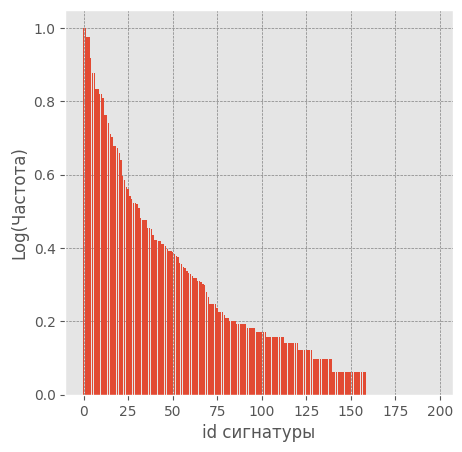

In [4]:
freq_sig = alert_data[['src_ip', 'sig_id']].groupby('sig_id').count().src_ip.values
freq_sig.sort()

sig_id = range(freq_sig.shape[0])

fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_xlabel("id сигнатуры")
ax1.set_ylabel("Частота")
ax1.bar(sig_id, freq_sig[::-1] / max(freq_sig))
fig1.savefig('pic/sig_freq.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(5,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_xlabel("id сигнатуры")
ax2.set_ylabel("Log(Частота)")
ax2.bar(sig_id, np.log(freq_sig[::-1]) / np.log(max(freq_sig)))
fig2.savefig('pic/sig_freq_log.png')

## Signature Density 

In [5]:
start_timestamp = 1669722456
end_timestamp = 1669814078

alert_timestamps = np.array(
    [
        1 if t in alert_data.first_alert_time_sec.values else 0 
        for t in range(start_timestamp, end_timestamp)
    ]
)

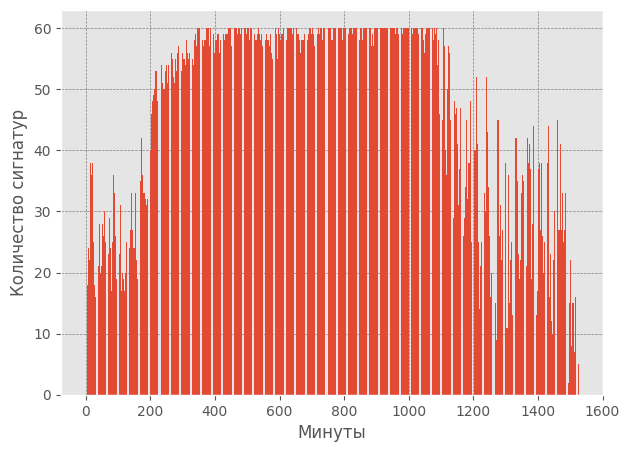

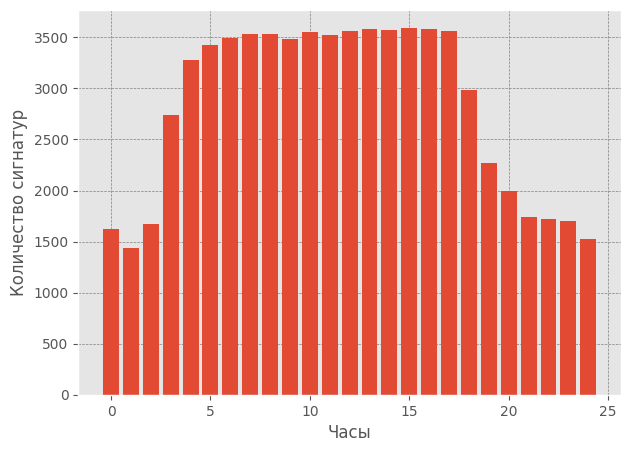

In [6]:
sig_density_minute = [
    np.array(period).nonzero()[0].shape[0] 
    for period in alert_timestamps[:-2].reshape(-1, 60)
]

sig_density_hour = [
    np.array(period).nonzero()[0].shape[0] 
    for period in alert_timestamps[:-1622].reshape(-1, 3600)
]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(7,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_xlabel("Минуты")
ax1.set_ylabel("Количество сигнатур")
ax1.bar(range(len(sig_density_minute)), sig_density_minute)
fig1.savefig('pic/sig_density_minute.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(7,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_xlabel("Часы")
ax2.set_ylabel("Количество сигнатур")
ax2.bar(range(len(sig_density_hour)), sig_density_hour)
fig2.savefig('pic/sig_density_hour.png')

In [7]:
alert_data.sig_id.unique().shape

(198,)

## Flows count

In [9]:
# %%time
# count = 0
# i = 0
# for filename in flows_list:
#     for line in open(f"../dataset/netflow/flows/{filename}", encoding="cp1251"):
#         count+=1
#     i+=1
# print(count)

## Samples Load

In [9]:
ident_features = [
    'src_ip', 'dst_ip', 
    'src_port', 'dst_port'
]
port_features = [
    'src_port', 
    'dst_port'
]
ip_features = [
    'ip_proto_x', 
    'ip_proto_pkt_cnt',
    'ip_proto_bytes_cnt',
]
udp_features = [
    'udp_proto_pkt_cnt',
    'udp_proto_bytes_cnt', 
]
tcp_features = [
    'tcp_proto_pkt_cnt',
    'tcp_proto_bytes_cnt', 
    'tcp_proto_syn_cnt', 
    'tcp_proto_fin_cnt',
    'tcp_proto_ack_cnt', 
    'tcp_proto_psh_cnt',
    'tcp_proto_rst_cnt',
    'tcp_proto_synack_cnt',
]
icmp_features = [
    'icmp_proto_pkt_cnt',
    'icmp_proto_bytes_cnt',
    'icmp_proto_echo_request_cnt',
    'icmp_proto_echo_reply_cnt'
]
http_features = [
    'http_proto_get_pkt_cnt', 
    'http_proto_post_pkt_cnt',
    'http_proto_http_pkt_cnt',
    'http_proto_200_pkt_cnt',
    'http_proto_301_pkt_cnt', 
    'http_proto_302_pkt_cnt',
    'http_proto_304_pkt_cnt', 
    'http_proto_400_pkt_cnt',
    'http_proto_401_pkt_cnt', 
    'http_proto_403_pkt_cnt',
    'http_proto_404_pkt_cnt', 
    'http_proto_429_pkt_cnt',
    'http_proto_500_pkt_cnt', 
    'http_proto_503_pkt_cnt',
    'http_proto_511_pkt_cnt'
]
dns_features = [
    'dns_query_cnt', 
    'dns_response_cnt'
]
pkt_features = (
      ip_features 
    + tcp_features 
    + icmp_features 
    + http_features 
    + dns_features
    + udp_features
    + port_features
)
timestamp_features = [
    'first_alert_time_sec',
    'last_alert_time_sec',
    'first_pkt_time_sec',
    'last_pkt_time_sec'
]

In [6]:
sample_size = 100
sample_list = flows_list[:sample_size]

In [7]:
flow_samples = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"dataset/netflow/flow/{filename}", 
                    names=netflow_fields,  
                    encoding="cp1251"
                ) for filename in sample_list[s:s+5]
            ],
            ignore_index=True
        ).merge(
            alert_data, 
            how='left', 
            on=ident_features,
            indicator=True
        ) [
            timestamp_features 
            #+ ip_features 
            #+ tcp_features 
            #+ icmp_features 
            + http_features 
            #+ dns_features
            #+ udp_features
            #+ port_features
            + ['_merge']
        ] 
        for s in range(0, sample_size, 5)
    ],
    ignore_index=True
)
flow_samples['is_alert'] = flow_samples['_merge'].replace(
    {
        'both': 1, 'left_only': 0, 'right_only': 0
    },
)
flow_samples = flow_samples[
    (
        (
            flow_samples.is_alert == 1
        ) & (
            flow_samples.first_alert_time_sec >= flow_samples.first_pkt_time_sec
        ) & (
            flow_samples.first_alert_time_sec <= flow_samples.last_pkt_time_sec
        ) & (
            flow_samples.last_alert_time_sec <= flow_samples.last_pkt_time_sec
        )
    ) | (
        flow_samples.is_alert == 0
    )
]

In [8]:
pure_flows, alert_flows = (
    flow_samples[flow_samples.is_alert == 0],
    flow_samples[flow_samples.is_alert == 1]
)

In [9]:
sample_size, pure_size, alert_size = (
    flow_samples.shape[0],
    pure_flows  .shape[0],
    alert_flows .shape[0]
)
sample_size, pure_size, alert_size, alert_size / pure_size

(32546777, 32514842, 31935, 0.0009821668516796114)

## Port

In [31]:
features_group = port_features

In [32]:
flow_samples[features_group].describe()

,src_port,dst_port
count,6.686979e+07,6.686979e+07
mean,3.011367e+04,2.126792e+04
std,2.478535e+04,2.374948e+04
min,0.000000e+00,0.000000e+00
25%,4.430000e+02,4.430000e+02
50%,3.757100e+04,8.805000e+03
75%,5.376400e+04,4.701600e+04
max,6.553500e+04,6.553500e+04


In [33]:
alert_flows[features_group].describe()

,src_port,dst_port
count,57933.000000,57933.000000
mean,45202.404398,2770.130064
std,14172.328577,6305.689440
min,0.000000,0.000000
25%,40759.000000,443.000000
50%,48688.000000,1433.000000
75%,55052.000000,3306.000000
max,65530.000000,65427.000000


In [34]:
pure_flows[features_group].describe()

,src_port,dst_port
count,6.681186e+07,6.681186e+07
mean,3.010059e+04,2.128396e+04
std,2.478860e+04,2.375280e+04
min,0.000000e+00,0.000000e+00
25%,4.430000e+02,4.430000e+02
50%,3.753000e+04,8.819000e+03
75%,5.376100e+04,4.703400e+04
max,6.553500e+04,6.553500e+04


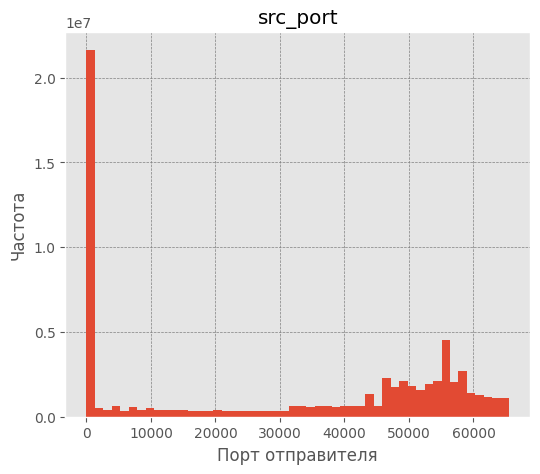

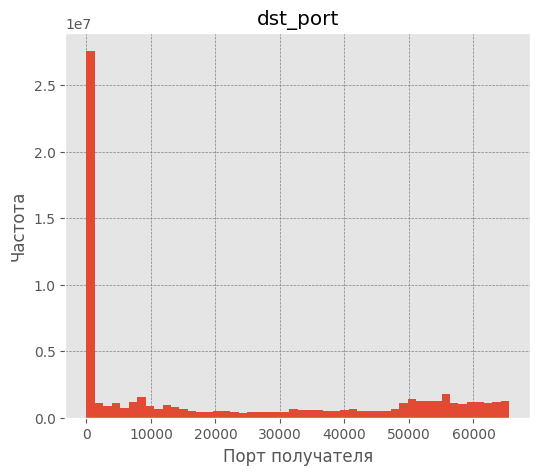

In [51]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("src_port")
ax1.set_xlabel("Порт отправителя")
ax1.set_ylabel("Частота")
ax1.hist(flow_samples['src_port'], bins=50)
fig1.savefig('pic/src_port_all_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("dst_port")
ax2.set_xlabel("Порт получателя")
ax2.set_ylabel("Частота")
ax2.hist(flow_samples['dst_port'], bins=50)
fig2.savefig('pic/dst_port_all_hist.png')

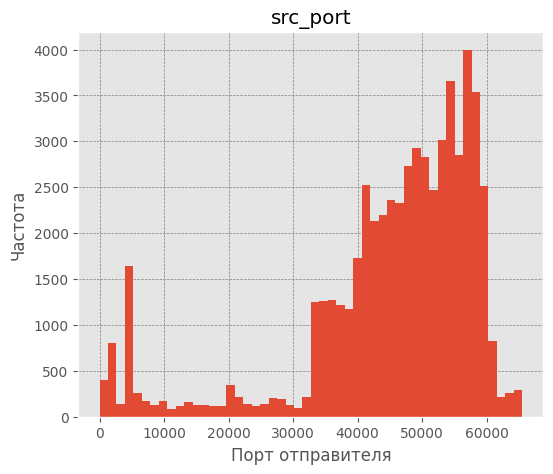

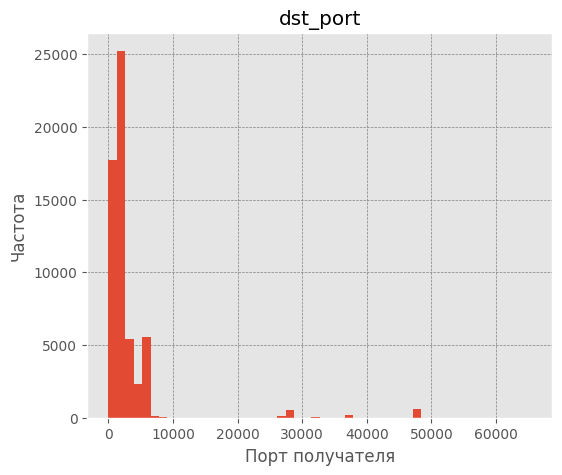

In [52]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("src_port")
ax1.set_xlabel("Порт отправителя")
ax1.set_ylabel("Частота")
ax1.hist(alert_flows['src_port'], bins=50)
fig1.savefig('pic/src_port_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("dst_port")
ax2.set_xlabel("Порт получателя")
ax2.set_ylabel("Частота")
ax2.hist(alert_flows['dst_port'], bins=50)
fig2.savefig('pic/dst_port_alert_hist.png')

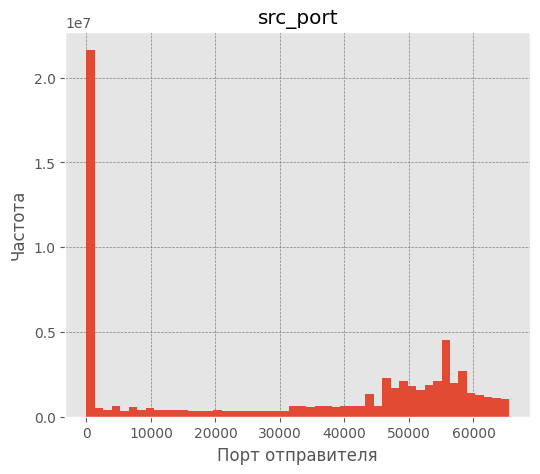

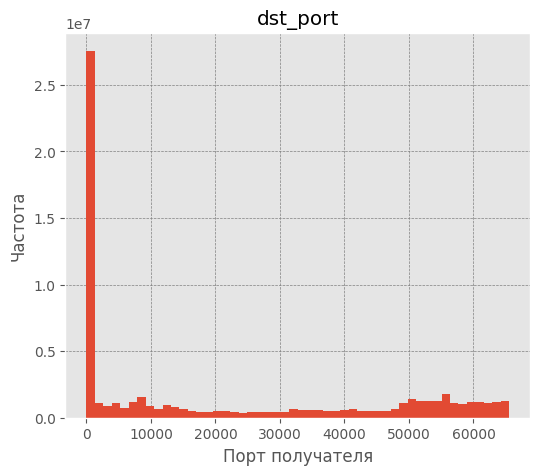

In [53]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("src_port")
ax1.set_xlabel("Порт отправителя")
ax1.set_ylabel("Частота")
ax1.hist(pure_flows['src_port'], bins=50)
fig1.savefig('pic/src_port_pure_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("dst_port")
ax2.set_xlabel("Порт получателя")
ax2.set_ylabel("Частота")
ax2.hist(pure_flows['dst_port'], bins=50)
fig2.savefig('pic/dst_port_pure_hist.png')

## IP

In [15]:
features_group = ip_features

In [16]:
features_group

['ip_proto_x', 'ip_proto_pkt_cnt', 'ip_proto_bytes_cnt']

In [17]:
flow_samples[features_group].describe()

,ip_proto_x,ip_proto_pkt_cnt,ip_proto_bytes_cnt
count,66869789.0,6.686979e+07,6.686979e+07
mean,0.0,6.383809e+01,5.904850e+04
std,0.0,1.946218e+03,2.553141e+06
min,0.0,1.000000e+00,2.800000e+01
25%,0.0,2.000000e+00,8.000000e+01
50%,0.0,2.000000e+00,2.000000e+02
75%,0.0,8.000000e+00,1.018000e+03
max,0.0,1.849958e+06,2.626891e+09


In [18]:
alert_flows[features_group].describe()

,ip_proto_x,ip_proto_pkt_cnt,ip_proto_bytes_cnt
count,57933.0,57933.000000,5.793300e+04
mean,0.0,9.842180,9.849239e+02
std,0.0,404.040346,3.508633e+04
min,0.0,1.000000,2.800000e+01
25%,0.0,2.000000,8.000000e+01
50%,0.0,2.000000,8.800000e+01
75%,0.0,3.000000,1.440000e+02
max,0.0,41820.000000,3.512880e+06


In [19]:
pure_flows[features_group].describe()

,ip_proto_x,ip_proto_pkt_cnt,ip_proto_bytes_cnt
count,66811856.0,6.681186e+07,6.681186e+07
mean,0.0,6.388491e+01,5.909885e+04
std,0.0,1.947024e+03,2.554247e+06
min,0.0,1.000000e+00,2.800000e+01
25%,0.0,2.000000e+00,8.000000e+01
50%,0.0,2.000000e+00,2.000000e+02
75%,0.0,8.000000e+00,1.020000e+03
max,0.0,1.849958e+06,2.626891e+09


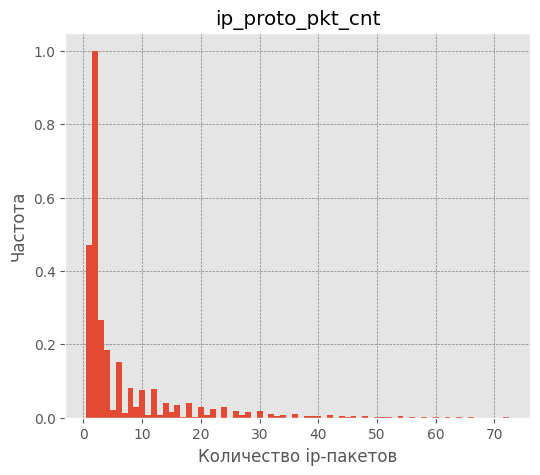

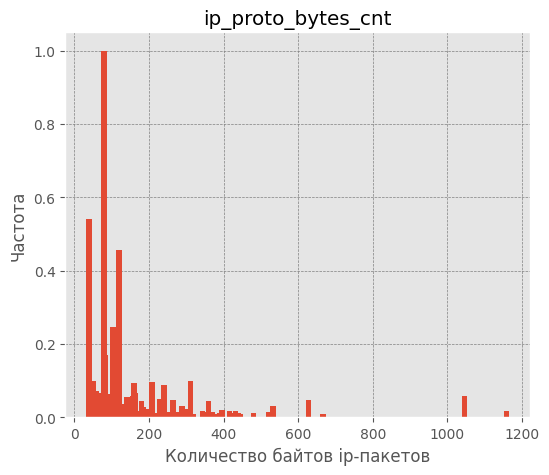

In [20]:
freq_ip_pkt = flow_samples[
    ['_merge', 'ip_proto_pkt_cnt', 'is_alert']
].groupby(
    'ip_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_ip_bytes = flow_samples[
    ['_merge', 'ip_proto_bytes_cnt', 'is_alert']
].groupby(
    'ip_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index = freq_ip_pkt.index[:50]
index_bytes = freq_ip_bytes.index[:100]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("ip_proto_pkt_cnt")
ax1.set_xlabel("Количество ip-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index, freq_ip_pkt.loc[index]._merge / max(freq_ip_pkt._merge),
        width=1
)
fig1.savefig('pic/ip_proto_pkt_cnt_all_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("ip_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов ip-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_bytes, 
        freq_ip_bytes.loc[index_bytes]._merge / max(freq_ip_bytes._merge),
        width=15
)
fig2.savefig('pic/ip_proto_bytes_cnt_all_hist.png')

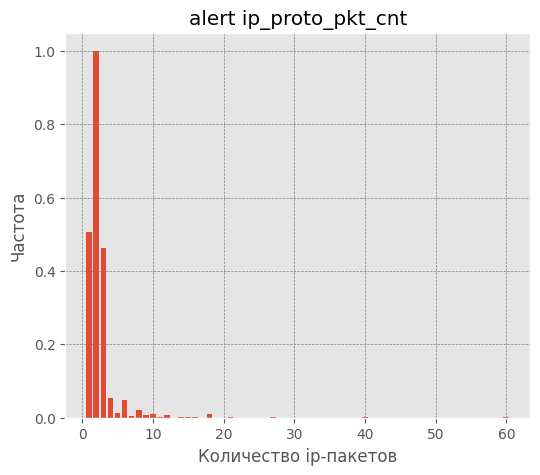

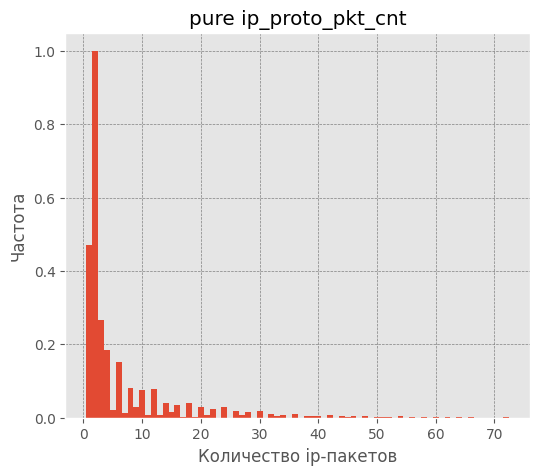

In [21]:
freq_ip_pkt_alert = alert_flows[
    ['_merge', 'ip_proto_pkt_cnt', 'is_alert']
].groupby(
    'ip_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_ip_pkt_pure = pure_flows[
    ['_merge', 'ip_proto_pkt_cnt', 'is_alert']
].groupby(
    'ip_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_ip_pkt_alert.index[:20]
i_pure = freq_ip_pkt_pure.index[:50]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert ip_proto_pkt_cnt")
ax1.set_xlabel("Количество ip-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_ip_pkt_alert.loc[i_alert]._merge / max(freq_ip_pkt_alert._merge),
        width=0.8
)
fig1.savefig('pic/ip_proto_pkt_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure ip_proto_pkt_cnt")
ax2.set_xlabel("Количество ip-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_ip_pkt_pure.loc[i_pure]._merge / max(freq_ip_pkt_pure._merge),
        width=1
)
fig2.savefig('pic/ip_proto_pkt_cnt_pure_hist.png')


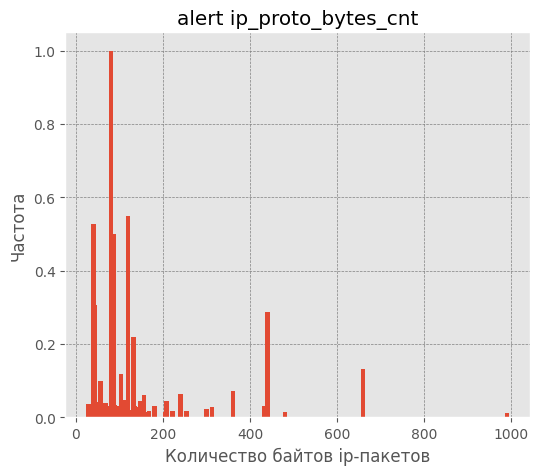

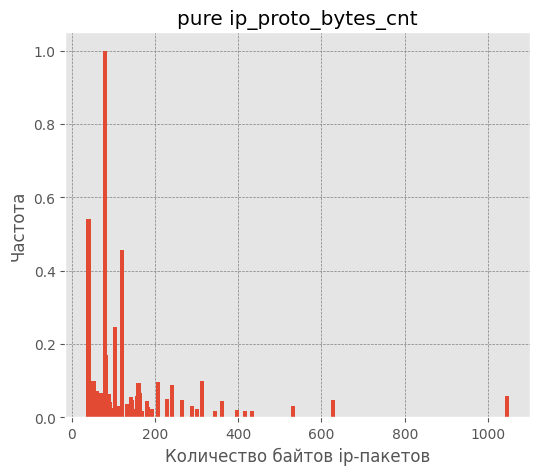

In [22]:
freq_ip_bytes_alert = alert_flows[
    ['_merge', 'ip_proto_bytes_cnt', 'is_alert']
].groupby(
    'ip_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_ip_bytes_pure = pure_flows[
    ['_merge', 'ip_proto_bytes_cnt', 'is_alert']
].groupby(
    'ip_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_ip_bytes_alert.index[:50]
i_pure = freq_ip_bytes_pure.index[:50]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert ip_proto_bytes_cnt")
ax1.set_xlabel("Количество байтов ip-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_ip_bytes_alert.loc[i_alert]._merge / max(freq_ip_bytes_alert._merge),
        width=10
)
fig1.savefig('pic/ip_proto_bytes_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure ip_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов ip-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_ip_bytes_pure.loc[i_pure]._merge / max(freq_ip_bytes_pure._merge),
        width=10
)
fig2.savefig('pic/ip_proto_bytes_cnt_pure_hist.png')


## TCP

In [23]:
features_group = tcp_features

In [24]:
features_group

['tcp_proto_pkt_cnt',
 'tcp_proto_bytes_cnt',
 'tcp_proto_syn_cnt',
 'tcp_proto_fin_cnt',
 'tcp_proto_ack_cnt',
 'tcp_proto_psh_cnt',
 'tcp_proto_rst_cnt',
 'tcp_proto_synack_cnt']

In [25]:
flow_samples[features_group].describe()

,tcp_proto_pkt_cnt,tcp_proto_bytes_cnt,tcp_proto_syn_cnt,tcp_proto_fin_cnt,tcp_proto_ack_cnt,tcp_proto_psh_cnt,tcp_proto_rst_cnt,tcp_proto_synack_cnt
count,6.686979e+07,6.686979e+07,6.686979e+07,6.686979e+07,6.686979e+07,6.686979e+07,6.686979e+07,6.686979e+07
mean,5.208243e+01,4.913336e+04,1.097311e+00,3.961892e-01,5.121997e+01,6.563436e+00,1.247432e-01,5.201305e+01
std,1.768254e+03,2.381449e+06,3.022068e+00,1.296816e+00,1.768219e+03,1.815920e+02,4.838870e+00,1.768203e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,6.000000e+00,3.540000e+02,2.000000e+00,0.000000e+00,6.000000e+00,2.000000e+00,0.000000e+00,6.000000e+00
max,1.849958e+06,2.589892e+09,1.130100e+04,2.868000e+03,1.849958e+06,1.542250e+05,5.841000e+03,1.849958e+06


In [26]:
alert_flows[features_group].describe()

,tcp_proto_pkt_cnt,tcp_proto_bytes_cnt,tcp_proto_syn_cnt,tcp_proto_fin_cnt,tcp_proto_ack_cnt,tcp_proto_psh_cnt,tcp_proto_rst_cnt,tcp_proto_synack_cnt
count,57933.000000,57933.000000,57933.000000,57933.000000,57933.00000,57933.000000,57933.000000,57933.000000
mean,2.639532,310.883003,1.713289,0.047572,0.90168,0.218494,0.033383,2.607926
std,33.742861,9085.318826,2.060626,0.431388,33.62228,2.905204,0.453253,33.722420
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,40.000000,2.000000,0.000000,0.00000,0.000000,0.000000,2.000000
75%,2.000000,60.000000,2.000000,0.000000,0.00000,0.000000,0.000000,2.000000
max,6224.000000,975474.000000,134.000000,45.000000,6222.00000,366.000000,80.000000,6224.000000


In [27]:
pure_flows[features_group].describe()

,tcp_proto_pkt_cnt,tcp_proto_bytes_cnt,tcp_proto_syn_cnt,tcp_proto_fin_cnt,tcp_proto_ack_cnt,tcp_proto_psh_cnt,tcp_proto_rst_cnt,tcp_proto_synack_cnt
count,6.681186e+07,6.681186e+07,6.681186e+07,6.681186e+07,6.681186e+07,6.681186e+07,6.681186e+07,6.681186e+07
mean,5.212530e+01,4.917570e+04,1.096777e+00,3.964915e-01,5.126360e+01,6.568937e+00,1.248224e-01,5.205589e+01
std,1.769019e+03,2.382481e+06,3.022715e+00,1.297276e+00,1.768984e+03,1.816706e+02,4.840948e+00,1.768968e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,6.000000e+00,3.540000e+02,2.000000e+00,0.000000e+00,6.000000e+00,2.000000e+00,0.000000e+00,6.000000e+00
max,1.849958e+06,2.589892e+09,1.130100e+04,2.868000e+03,1.849958e+06,1.542250e+05,5.841000e+03,1.849958e+06


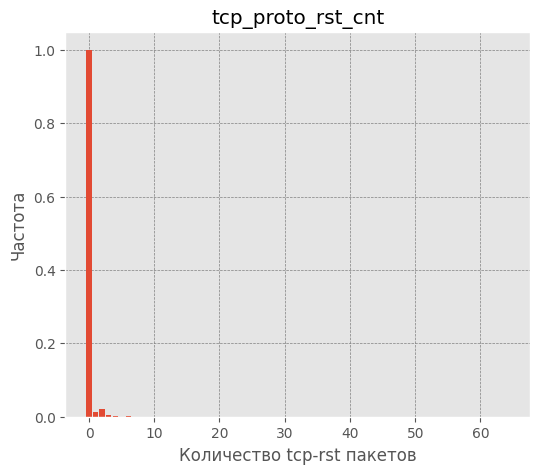

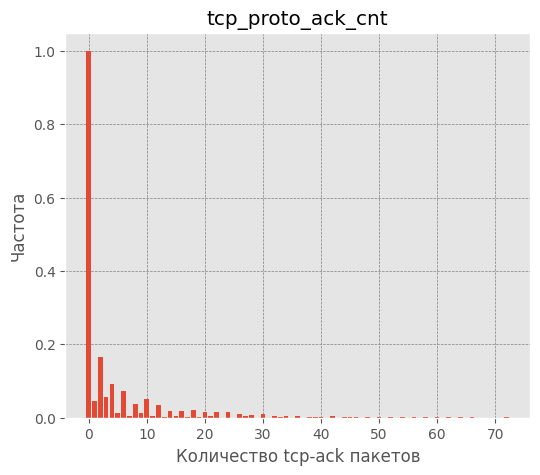

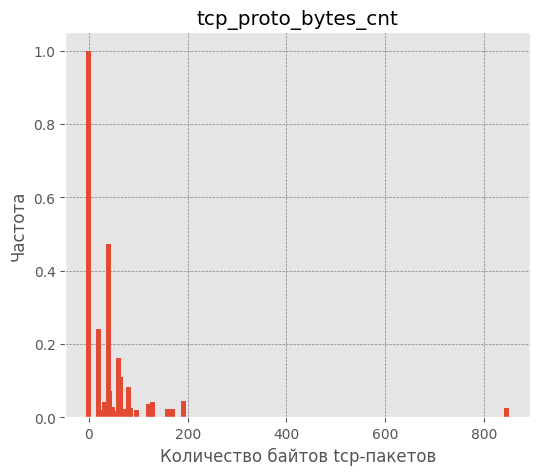

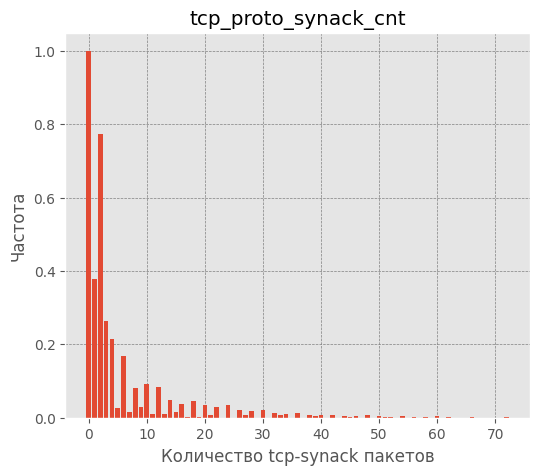

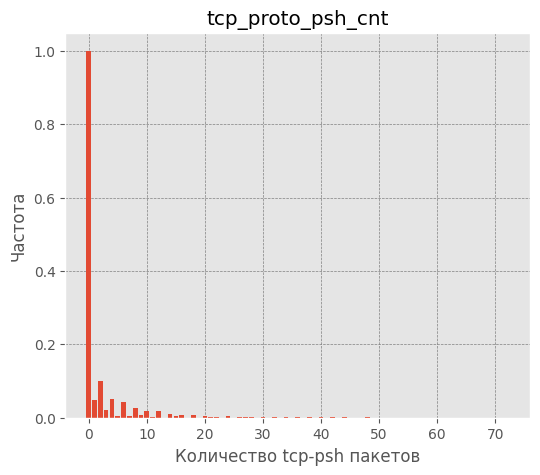

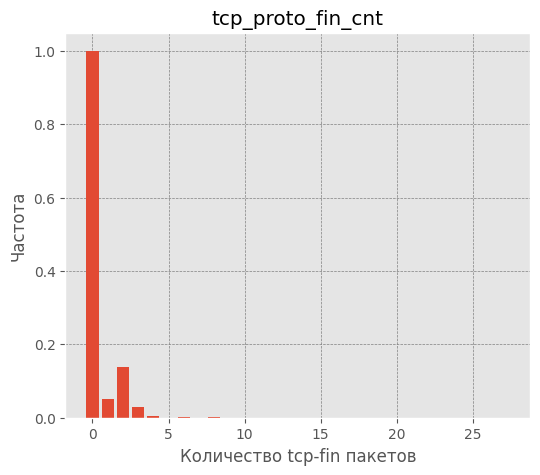

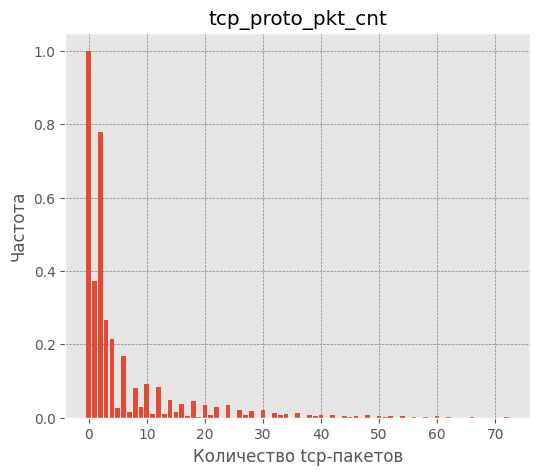

In [28]:
freq_tcp_proto_pkt_cnt = flow_samples[
    ['_merge', 'tcp_proto_pkt_cnt', 'is_alert']
].groupby(
    'tcp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_bytes_cnt = flow_samples[
    ['_merge', 'tcp_proto_bytes_cnt', 'is_alert']
].groupby(
    'tcp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_syn_cnt = flow_samples[
    ['_merge', 'tcp_proto_syn_cnt', 'is_alert']
].groupby(
    'tcp_proto_syn_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_fin_cnt = flow_samples[
    ['_merge', 'tcp_proto_fin_cnt', 'is_alert']
].groupby(
    'tcp_proto_fin_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_ack_cnt = flow_samples[
    ['_merge', 'tcp_proto_ack_cnt', 'is_alert']
].groupby(
    'tcp_proto_ack_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_psh_cnt = flow_samples[
    ['_merge', 'tcp_proto_psh_cnt', 'is_alert']
].groupby(
    'tcp_proto_psh_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_synack_cnt = flow_samples[
    ['_merge', 'tcp_proto_synack_cnt', 'is_alert']
].groupby(
    'tcp_proto_synack_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_tcp_proto_rst_cnt = flow_samples[
    ['_merge', 'tcp_proto_rst_cnt', 'is_alert']
].groupby(
    'tcp_proto_rst_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_tcp_proto_rst_cnt = freq_tcp_proto_rst_cnt.index[:50]
index_tcp_proto_ack_cnt = freq_tcp_proto_ack_cnt.index[:50]
index_tcp_proto_bytes_cnt = freq_tcp_proto_bytes_cnt.index[:20]
index_tcp_proto_synack_cnt = freq_tcp_proto_synack_cnt.index[:50]
index_tcp_proto_psh_cnt = freq_tcp_proto_psh_cnt.index[:50]
index_tcp_proto_fin_cnt = freq_tcp_proto_fin_cnt.index[:20]
index_tcp_proto_pkt_cnt = freq_tcp_proto_pkt_cnt.index[:50]


fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("tcp_proto_rst_cnt")
ax1.set_xlabel("Количество tcp-rst пакетов")
ax1.set_ylabel("Частота")
ax1.bar(
    index_tcp_proto_rst_cnt, 
    freq_tcp_proto_rst_cnt.loc[index_tcp_proto_rst_cnt]._merge / max(freq_tcp_proto_rst_cnt._merge),
    width=0.8
)
fig1.savefig('pic/tcp_proto_rst_cnt_all_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("tcp_proto_ack_cnt")
ax2.set_xlabel("Количество tcp-ack пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_tcp_proto_ack_cnt, 
        freq_tcp_proto_ack_cnt.loc[index_tcp_proto_ack_cnt]._merge / max(freq_tcp_proto_ack_cnt._merge),
        width=0.8
)
fig2.savefig('pic/tcp_proto_ack_cnt_all_hist.png')


fig3, ax3 = plt.subplots()
fig3.set_size_inches(6,5)
ax3.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax3.set_title("tcp_proto_bytes_cnt")
ax3.set_xlabel("Количество байтов tcp-пакетов")
ax3.set_ylabel("Частота")
ax3.bar(index_tcp_proto_bytes_cnt, 
        freq_tcp_proto_bytes_cnt.loc[index_tcp_proto_bytes_cnt]._merge / max(freq_tcp_proto_bytes_cnt._merge),
        width=10
)
fig3.savefig('pic/tcp_proto_bytes_cnt_all_hist.png')


fig4, ax4 = plt.subplots()
fig4.set_size_inches(6,5)
ax4.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax4.set_title("tcp_proto_synack_cnt")
ax4.set_xlabel("Количество tcp-synack пакетов")
ax4.set_ylabel("Частота")
ax4.bar(index_tcp_proto_synack_cnt, 
        freq_tcp_proto_synack_cnt.loc[index_tcp_proto_synack_cnt]._merge / max(freq_tcp_proto_synack_cnt._merge),
        width=0.8
)
fig4.savefig('pic/tcp_proto_synack_cnt_all_hist.png')


fig5, ax5 = plt.subplots()
fig5.set_size_inches(6,5)
ax5.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax5.set_title("tcp_proto_psh_cnt")
ax5.set_xlabel("Количество tcp-psh пакетов")
ax5.set_ylabel("Частота")
ax5.bar(index_tcp_proto_psh_cnt, 
        freq_tcp_proto_psh_cnt.loc[index_tcp_proto_psh_cnt]._merge / max(freq_tcp_proto_psh_cnt._merge),
        width=0.8
)
fig5.savefig('pic/tcp_proto_psh_cnt_all_hist.png')


fig6, ax6 = plt.subplots()
fig6.set_size_inches(6,5)
ax6.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax6.set_title("tcp_proto_fin_cnt")
ax6.set_xlabel("Количество tcp-fin пакетов")
ax6.set_ylabel("Частота")
ax6.bar(index_tcp_proto_fin_cnt, 
        freq_tcp_proto_fin_cnt.loc[index_tcp_proto_fin_cnt]._merge / max(freq_tcp_proto_fin_cnt._merge),
        width=0.8
)
fig6.savefig('pic/tcp_proto_fin_cnt_all_hist.png')


fig7, ax7 = plt.subplots()
fig7.set_size_inches(6,5)
ax7.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax7.set_title("tcp_proto_pkt_cnt")
ax7.set_xlabel("Количество tcp-пакетов")
ax7.set_ylabel("Частота")
ax7.bar(index_tcp_proto_pkt_cnt, 
        freq_tcp_proto_pkt_cnt.loc[index_tcp_proto_pkt_cnt]._merge / max(freq_tcp_proto_pkt_cnt._merge),
        width=0.8
)
fig7.savefig('pic/tcp_proto_pkt_cnt_all_hist.png')

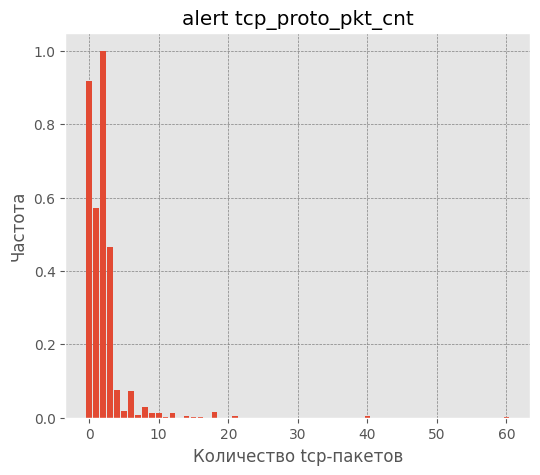

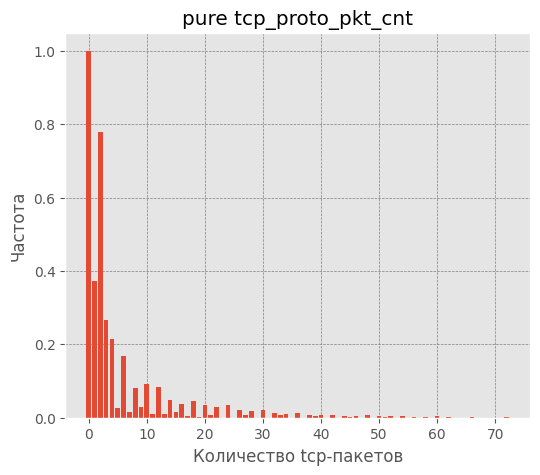

In [29]:
freq_tcp_pkt_alert = alert_flows[
    ['_merge', 'tcp_proto_pkt_cnt', 'is_alert']
].groupby(
    'tcp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_tcp_pkt_pure = pure_flows[
    ['_merge', 'tcp_proto_pkt_cnt', 'is_alert']
].groupby(
    'tcp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_tcp_pkt_alert.index[:20]
i_pure = freq_tcp_pkt_pure.index[:50]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert tcp_proto_pkt_cnt")
ax1.set_xlabel("Количество tcp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_tcp_pkt_alert.loc[i_alert]._merge / max(freq_tcp_pkt_alert._merge),
        width=0.8
)
fig1.savefig('pic/tcp_proto_pkt_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure tcp_proto_pkt_cnt")
ax2.set_xlabel("Количество tcp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_tcp_pkt_pure.loc[i_pure]._merge / max(freq_tcp_pkt_pure._merge),
        width=0.8
)
fig2.savefig('pic/tcp_proto_pkt_cnt_pure_hist.png')


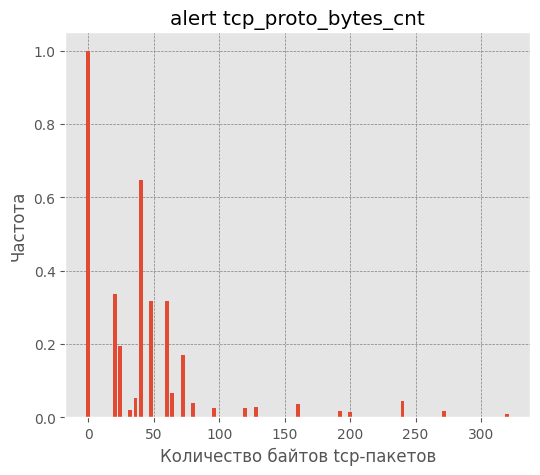

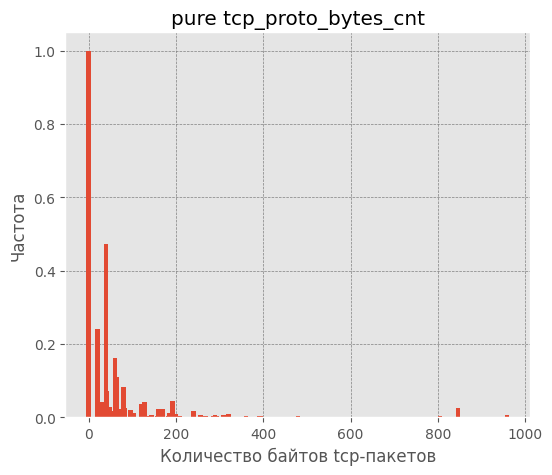

In [30]:
freq_tcp_bytes_alert = alert_flows[
    ['_merge', 'tcp_proto_bytes_cnt', 'is_alert']
].groupby(
    'tcp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_tcp_bytes_pure = pure_flows[
    ['_merge', 'tcp_proto_bytes_cnt', 'is_alert']
].groupby(
    'tcp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_tcp_bytes_alert.index[:20]
i_pure = freq_tcp_bytes_pure.index[:50]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert tcp_proto_bytes_cnt")
ax1.set_xlabel("Количество байтов tcp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_tcp_bytes_alert.loc[i_alert]._merge / max(freq_tcp_bytes_alert._merge),
        width=3
)
fig1.savefig('pic/tcp_proto_bytes_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure tcp_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов tcp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_tcp_bytes_pure.loc[i_pure]._merge / max(freq_tcp_bytes_pure._merge),
        width=10
)
fig2.savefig('pic/tcp_proto_bytes_cnt_pure_hist.png')


## ICMP 

In [15]:
features_group = icmp_features

In [16]:
features_group

['icmp_proto_pkt_cnt',
 'icmp_proto_bytes_cnt',
 'icmp_proto_echo_request_cnt',
 'icmp_proto_echo_reply_cnt']

In [17]:
flow_samples[features_group].describe()

,icmp_proto_pkt_cnt,icmp_proto_bytes_cnt,icmp_proto_echo_request_cnt,icmp_proto_echo_reply_cnt
count,6.510682e+07,6.510682e+07,6.510682e+07,6.510682e+07
mean,4.690612e-02,2.851850e+00,2.258507e-02,8.422328e-03
std,1.088756e+01,7.074322e+02,1.066429e+01,4.453092e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.182000e+04,2.676480e+06,4.182000e+04,4.040000e+02


In [18]:
alert_flows[features_group].describe()

,icmp_proto_pkt_cnt,icmp_proto_bytes_cnt,icmp_proto_echo_request_cnt,icmp_proto_echo_reply_cnt
count,63676.000000,6.367600e+04,63676.000000,63676.000000
mean,4.823199,2.882117e+02,4.813273,0.001570
std,340.435361,2.177632e+04,340.434123,0.396289
min,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000
max,41820.000000,2.676480e+06,41820.000000,100.000000


In [19]:
pure_flows[features_group].describe()

,icmp_proto_pkt_cnt,icmp_proto_bytes_cnt,icmp_proto_echo_request_cnt,icmp_proto_echo_reply_cnt
count,6.504314e+07,6.504314e+07,6.504314e+07,6.504314e+07
mean,4.223022e-02,2.572488e+00,1.789508e-02,8.429036e-03
std,2.274681e+00,1.914080e+02,5.985844e-01,4.453545e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.299000e+03,2.267640e+05,4.130000e+02,4.040000e+02


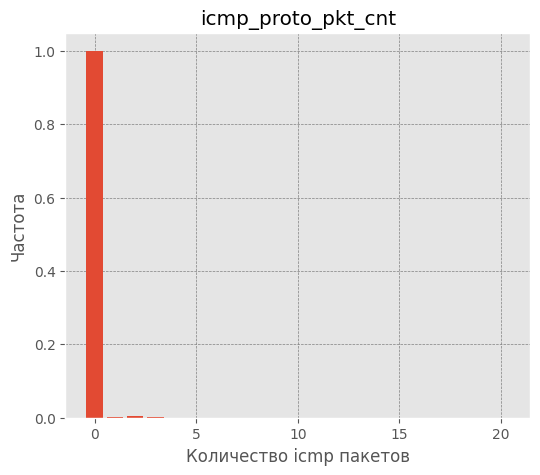

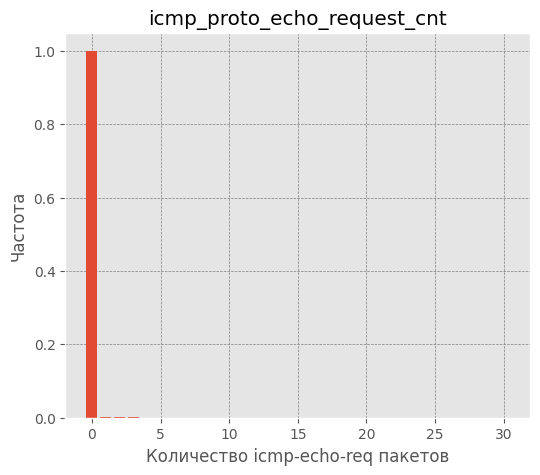

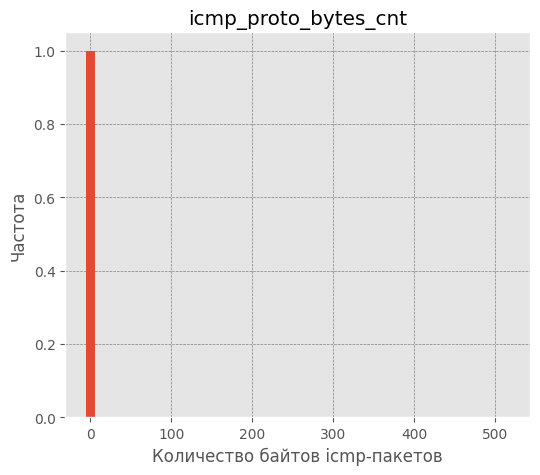

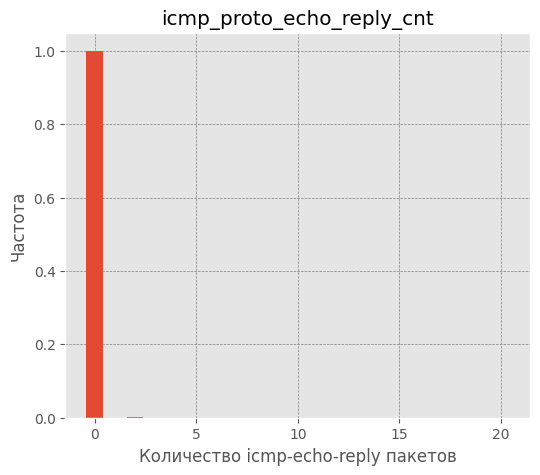

In [20]:
freq_icmp_proto_pkt_cnt = flow_samples[
    ['_merge', 'icmp_proto_pkt_cnt', 'is_alert']
].groupby(
    'icmp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_icmp_proto_bytes_cnt = flow_samples[
    ['_merge', 'icmp_proto_bytes_cnt', 'is_alert']
].groupby(
    'icmp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_icmp_proto_echo_request_cnt = flow_samples[
    ['_merge', 'icmp_proto_echo_request_cnt', 'is_alert']
].groupby(
    'icmp_proto_echo_request_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_icmp_proto_echo_reply_cnt = flow_samples[
    ['_merge', 'icmp_proto_echo_reply_cnt', 'is_alert']
].groupby(
    'icmp_proto_echo_reply_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_icmp_proto_pkt_cnt = freq_icmp_proto_pkt_cnt.index[:10]
index_icmp_proto_bytes_cnt = freq_icmp_proto_bytes_cnt.index[:10]
index_icmp_proto_echo_request_cnt = freq_icmp_proto_echo_request_cnt.index[:10]
index_icmp_proto_echo_reply_cnt = freq_icmp_proto_echo_reply_cnt.index[:10]


fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("icmp_proto_pkt_cnt")
ax1.set_xlabel("Количество icmp пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index_icmp_proto_pkt_cnt, 
        freq_icmp_proto_pkt_cnt.loc[index_icmp_proto_pkt_cnt]._merge / max(freq_icmp_proto_pkt_cnt._merge),
        width=0.8
)
fig1.savefig('pic/icmp_proto_pkt_cnt_all_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("icmp_proto_echo_request_cnt")
ax2.set_xlabel("Количество icmp-echo-req пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_icmp_proto_echo_request_cnt, 
        freq_icmp_proto_echo_request_cnt.loc[index_icmp_proto_echo_request_cnt]._merge / max(freq_icmp_proto_echo_request_cnt._merge),
        width=0.8
)
fig2.savefig('pic/icmp_proto_echo_request_cnt_all_hist.png')


fig3, ax3 = plt.subplots()
fig3.set_size_inches(6,5)
ax3.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax3.set_title("icmp_proto_bytes_cnt")
ax3.set_xlabel("Количество байтов icmp-пакетов")
ax3.set_ylabel("Частота")
ax3.bar(index_icmp_proto_bytes_cnt, 
        freq_icmp_proto_bytes_cnt.loc[index_icmp_proto_bytes_cnt]._merge / max(freq_icmp_proto_bytes_cnt._merge),
        width=10
)
fig3.savefig('pic/icmp_proto_bytes_cnt_all_hist.png')


fig4, ax4 = plt.subplots()
fig4.set_size_inches(6,5)
ax4.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax4.set_title("icmp_proto_echo_reply_cnt")
ax4.set_xlabel("Количество icmp-echo-reply пакетов")
ax4.set_ylabel("Частота")
ax4.bar(index_icmp_proto_echo_reply_cnt, 
        freq_icmp_proto_echo_reply_cnt.loc[index_icmp_proto_echo_reply_cnt]._merge / max(freq_icmp_proto_echo_reply_cnt._merge),
        width=0.8
)
fig4.savefig('pic/icmp_proto_echo_reply_cnt_all_hist.png')

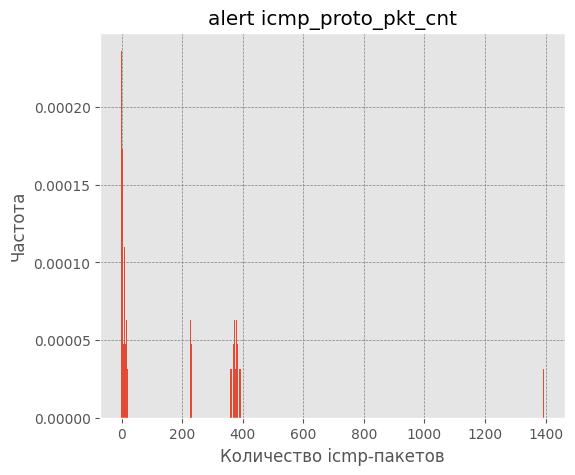

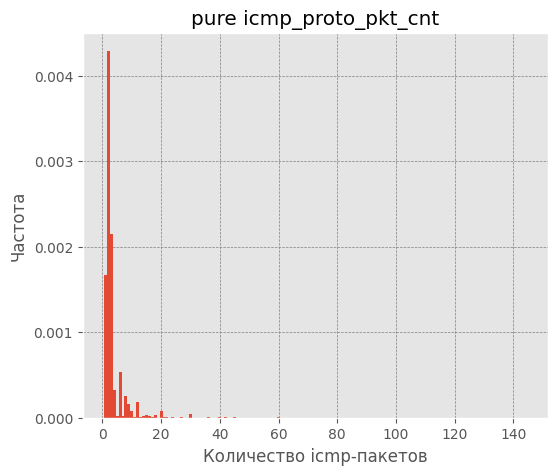

In [21]:
freq_icmp_pkt_alert = alert_flows[
    ['_merge', 'icmp_proto_pkt_cnt', 'is_alert']
].groupby(
    'icmp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_icmp_pkt_pure = pure_flows[
    ['_merge', 'icmp_proto_pkt_cnt', 'is_alert']
].groupby(
    'icmp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_icmp_pkt_alert.index[1:30]
i_pure = freq_icmp_pkt_pure.index[1:80]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert icmp_proto_pkt_cnt")
ax1.set_xlabel("Количество icmp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_icmp_pkt_alert.loc[i_alert]._merge / max(freq_icmp_pkt_alert._merge),
        width=3
)
fig1.savefig('pic/_icmp_proto_pkt_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure icmp_proto_pkt_cnt")
ax2.set_xlabel("Количество icmp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_icmp_pkt_pure.loc[i_pure]._merge / max(freq_icmp_pkt_pure._merge),
        width=1
)
fig2.savefig('pic/_icmp_proto_pkt_cnt_pure_hist.png')


## DNS

In [11]:
features_group = dns_features

In [12]:
features_group

['dns_query_cnt', 'dns_response_cnt']

In [13]:
flow_samples[features_group].describe()

,dns_query_cnt,dns_response_cnt
count,6.571008e+07,6.571008e+07
mean,2.365962e-01,1.740204e-01
std,2.390837e+02,1.291120e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,7.836720e+05,3.038000e+03


In [14]:
alert_flows[features_group].describe()

,dns_query_cnt,dns_response_cnt
count,62246.000000,62246.0
mean,0.035520,0.0
std,1.389092,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,208.000000,0.0


In [15]:
pure_flows[features_group].describe()

,dns_query_cnt,dns_response_cnt
count,6.564784e+07,6.564784e+07
mean,2.367869e-01,1.741854e-01
std,2.391971e+02,1.291721e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,7.836720e+05,3.038000e+03


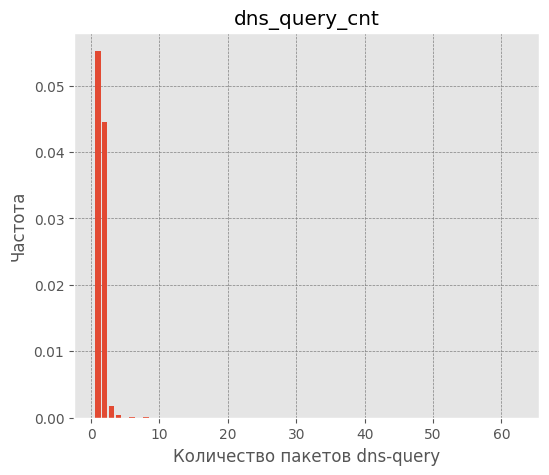

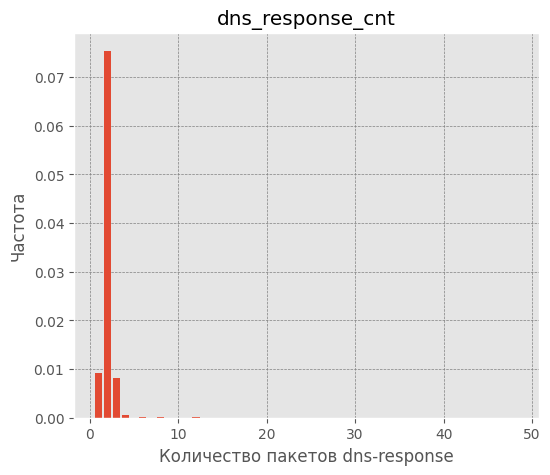

In [16]:
freq_dns_response_cnt = flow_samples[
    ['_merge', 'dns_response_cnt', 'is_alert']
].groupby(
    'dns_response_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_dns_query_cnt = flow_samples[
    ['_merge', 'dns_query_cnt', 'is_alert']
].groupby(
    'dns_query_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_dns_query_cnt = freq_dns_query_cnt.index[1:20]
index_dns_response_cnt = freq_dns_response_cnt.index[1:20]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("dns_query_cnt")
ax1.set_xlabel("Количество пакетов dns-query")
ax1.set_ylabel("Частота")
ax1.bar(index_dns_query_cnt, 
        freq_dns_query_cnt.loc[index_dns_query_cnt]._merge / max(freq_dns_query_cnt._merge),
        width=0.8
)
fig1.savefig('pic/_dns_query_cnt_all_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("dns_response_cnt")
ax2.set_xlabel("Количество пакетов dns-response")
ax2.set_ylabel("Частота")
ax2.bar(index_dns_response_cnt, 
        freq_dns_response_cnt.loc[index_dns_response_cnt]._merge / max(freq_dns_response_cnt._merge),
        width=0.8
)
fig2.savefig('pic/_dns_response_cnt_all_hist.png')

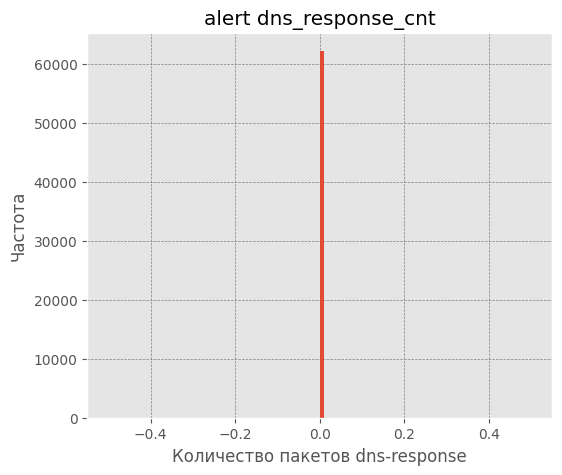

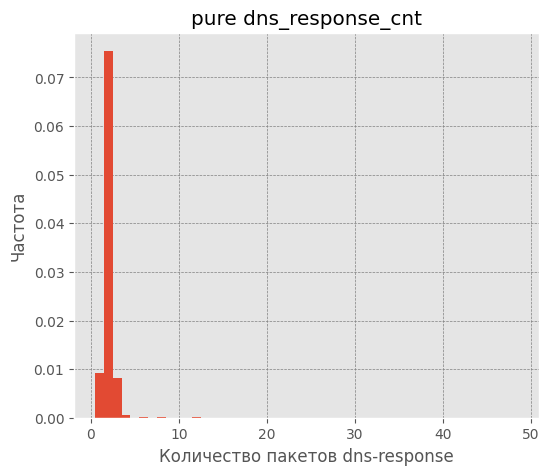

In [33]:
freq_dns_response_cnt_alert = alert_flows[
    ['_merge', 'dns_response_cnt', 'is_alert']
].groupby(
    'dns_response_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_dns_response_cnt_pure = pure_flows[
    ['_merge', 'dns_response_cnt', 'is_alert']
].groupby(
    'dns_response_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_dns_response_cnt_alert.index
i_pure = freq_dns_response_cnt_pure.index[1:20]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert dns_response_cnt")
ax1.set_xlabel("Количество пакетов dns-response")
ax1.set_ylabel("Частота")
ax1.hist(alert_flows['dns_response_cnt'], bins=100)
fig1.savefig('pic/dns_response_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure dns_response_cnt")
ax2.set_xlabel("Количество пакетов dns-response")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_dns_response_cnt_pure.loc[i_pure]._merge / max(freq_dns_response_cnt_pure._merge),
        width=1
)
fig2.savefig('pic/_dns_response_cnt_pure_hist.png')

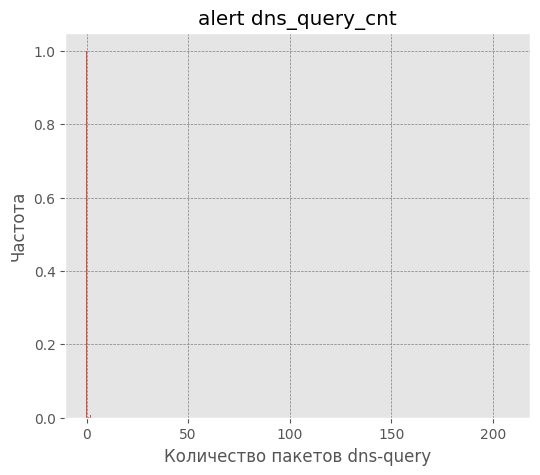

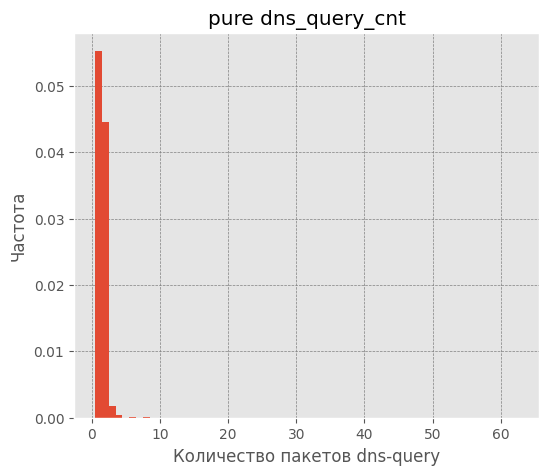

In [27]:
freq_dns_query_cnt_alert = alert_flows[
    ['_merge', 'dns_query_cnt', 'is_alert']
].groupby(
    'dns_query_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

freq_dns_query_cnt_pure = pure_flows[
    ['_merge', 'dns_query_cnt', 'is_alert']
].groupby(
    'dns_query_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

i_alert = freq_dns_query_cnt_alert.index[0:80]
i_pure = freq_dns_query_cnt_pure.index[1:20]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert dns_query_cnt")
ax1.set_xlabel("Количество пакетов dns-query")
ax1.set_ylabel("Частота")
ax1.bar(i_alert, 
        freq_dns_query_cnt_alert.loc[i_alert]._merge / max(freq_dns_query_cnt_alert._merge),
        width=0.1
)
fig1.savefig('pic/dns_query_cnt_alert_hist.png')

fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure dns_query_cnt")
ax2.set_xlabel("Количество пакетов dns-query")
ax2.set_ylabel("Частота")
ax2.bar(i_pure, 
        freq_dns_query_cnt_pure.loc[i_pure]._merge / max(freq_dns_query_cnt_pure._merge),
        width=1
)
fig2.savefig('pic/_dns_query_cnt_pure_hist.png')

## HTTP

In [10]:
features_group = http_features

In [11]:
flow_samples[features_group].describe()

,http_proto_get_pkt_cnt,http_proto_post_pkt_cnt,http_proto_http_pkt_cnt,http_proto_200_pkt_cnt,http_proto_301_pkt_cnt,http_proto_302_pkt_cnt,http_proto_304_pkt_cnt,http_proto_400_pkt_cnt,http_proto_401_pkt_cnt,http_proto_403_pkt_cnt,http_proto_404_pkt_cnt,http_proto_429_pkt_cnt,http_proto_500_pkt_cnt,http_proto_503_pkt_cnt,http_proto_511_pkt_cnt
count,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,3.254678e+07,32546777.0
mean,8.738211e-02,3.507598e-03,1.510070e-01,7.208668e-02,6.890483e-03,2.303638e-03,2.062478e-03,2.702907e-02,1.726745e-05,1.864056e-02,2.395875e-03,3.072501e-07,5.929927e-06,2.888151e-05,0.0
std,2.386142e+00,2.629912e-01,3.267312e+00,1.286772e+00,2.329116e+00,4.625659e-01,1.161846e-01,2.390296e-01,6.743346e-03,1.713760e+00,1.226311e-01,8.937842e-04,4.166485e-03,9.475107e-03,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,9.620000e+02,1.106000e+03,1.439000e+03,1.236000e+03,1.439000e+03,2.240000e+02,1.120000e+02,3.300000e+01,8.000000e+00,2.400000e+02,1.640000e+02,3.000000e+00,6.000000e+00,6.000000e+00,0.0


In [12]:
pure_flows[features_group].describe()

,http_proto_get_pkt_cnt,http_proto_post_pkt_cnt,http_proto_http_pkt_cnt,http_proto_200_pkt_cnt,http_proto_301_pkt_cnt,http_proto_302_pkt_cnt,http_proto_304_pkt_cnt,http_proto_400_pkt_cnt,http_proto_401_pkt_cnt,http_proto_403_pkt_cnt,http_proto_404_pkt_cnt,http_proto_429_pkt_cnt,http_proto_500_pkt_cnt,http_proto_503_pkt_cnt,http_proto_511_pkt_cnt
count,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,32514842.0
mean,8.743878e-02,3.510397e-03,1.511514e-01,7.215616e-02,6.897127e-03,2.305532e-03,2.064503e-03,2.705475e-02,1.728441e-05,1.865886e-02,2.397428e-03,3.075519e-07,5.935751e-06,2.890987e-05,0.0
std,2.387221e+00,2.631183e-01,3.268912e+00,1.287400e+00,2.330259e+00,4.627922e-01,1.162416e-01,2.391420e-01,6.746657e-03,1.714602e+00,1.226848e-01,8.942230e-04,4.168530e-03,9.479758e-03,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,9.620000e+02,1.106000e+03,1.439000e+03,1.236000e+03,1.439000e+03,2.240000e+02,1.120000e+02,3.300000e+01,8.000000e+00,2.400000e+02,1.640000e+02,3.000000e+00,6.000000e+00,6.000000e+00,0.0


In [13]:
pure_flows[features_group].describe()

,http_proto_get_pkt_cnt,http_proto_post_pkt_cnt,http_proto_http_pkt_cnt,http_proto_200_pkt_cnt,http_proto_301_pkt_cnt,http_proto_302_pkt_cnt,http_proto_304_pkt_cnt,http_proto_400_pkt_cnt,http_proto_401_pkt_cnt,http_proto_403_pkt_cnt,http_proto_404_pkt_cnt,http_proto_429_pkt_cnt,http_proto_500_pkt_cnt,http_proto_503_pkt_cnt,http_proto_511_pkt_cnt
count,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,3.251484e+07,32514842.0
mean,8.743878e-02,3.510397e-03,1.511514e-01,7.215616e-02,6.897127e-03,2.305532e-03,2.064503e-03,2.705475e-02,1.728441e-05,1.865886e-02,2.397428e-03,3.075519e-07,5.935751e-06,2.890987e-05,0.0
std,2.387221e+00,2.631183e-01,3.268912e+00,1.287400e+00,2.330259e+00,4.627922e-01,1.162416e-01,2.391420e-01,6.746657e-03,1.714602e+00,1.226848e-01,8.942230e-04,4.168530e-03,9.479758e-03,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
max,9.620000e+02,1.106000e+03,1.439000e+03,1.236000e+03,1.439000e+03,2.240000e+02,1.120000e+02,3.300000e+01,8.000000e+00,2.400000e+02,1.640000e+02,3.000000e+00,6.000000e+00,6.000000e+00,0.0


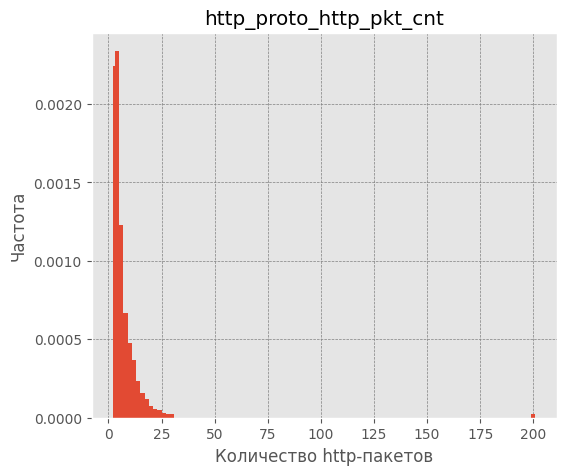

In [14]:
freq_http_proto_http_pkt_cnt = flow_samples[
    ['_merge', 'http_proto_http_pkt_cnt', 'is_alert']
].groupby(
    'http_proto_http_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_http_proto_http_pkt_cnt = freq_http_proto_http_pkt_cnt.index[3:20]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("http_proto_http_pkt_cnt")
ax1.set_xlabel("Количество http-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index_http_proto_http_pkt_cnt, 
        freq_http_proto_http_pkt_cnt.loc[index_http_proto_http_pkt_cnt]._merge / max(freq_http_proto_http_pkt_cnt._merge),
        width=2
)
fig1.savefig('pic/_http_proto_http_pkt_cnt_all_hist.png')

## UDP

In [51]:
features_group = udp_features

In [52]:
flow_samples[features_group].describe()

,udp_proto_pkt_cnt,udp_proto_bytes_cnt
count,6.510682e+07,6.510682e+07
mean,1.142823e+01,8.394264e+03
std,8.251659e+02,8.165677e+05
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,4.100000e+01
max,8.294150e+05,8.834718e+08


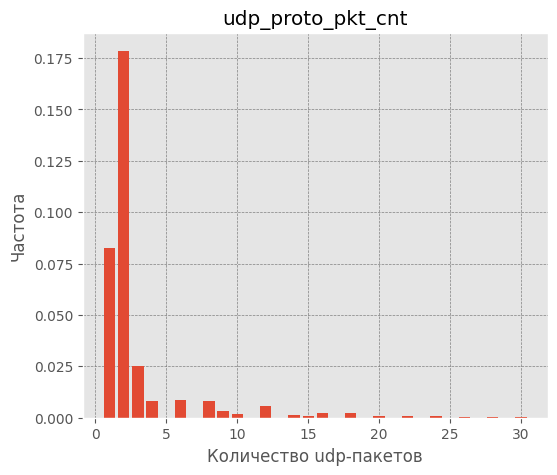

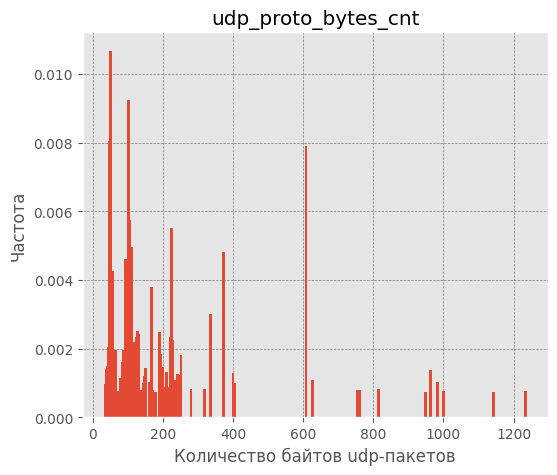

In [53]:
freq_udp_proto_pkt_cnt = flow_samples[
    ['_merge', 'udp_proto_pkt_cnt', 'is_alert']
].groupby(
    'udp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_udp_proto_bytes_cnt = flow_samples[
    ['_merge', 'udp_proto_bytes_cnt', 'is_alert']
].groupby(
    'udp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_udp_proto_pkt_cnt = freq_udp_proto_pkt_cnt.index[1:20]
index_udp_proto_bytes_cnt = freq_udp_proto_bytes_cnt.index[1:100]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("udp_proto_pkt_cnt")
ax1.set_xlabel("Количество udp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index_udp_proto_pkt_cnt, 
        freq_udp_proto_pkt_cnt.loc[index_udp_proto_pkt_cnt]._merge / max(freq_udp_proto_pkt_cnt._merge),
        width=0.8
)
fig1.savefig('pic/_udp_proto_pkt_cnt_all_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("udp_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов udp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_udp_proto_bytes_cnt, 
        freq_udp_proto_bytes_cnt.loc[index_udp_proto_bytes_cnt]._merge / max(freq_udp_proto_bytes_cnt._merge),
        width=8
)
fig2.savefig('pic/_udp_proto_bytes_cnt_all_hist.png')

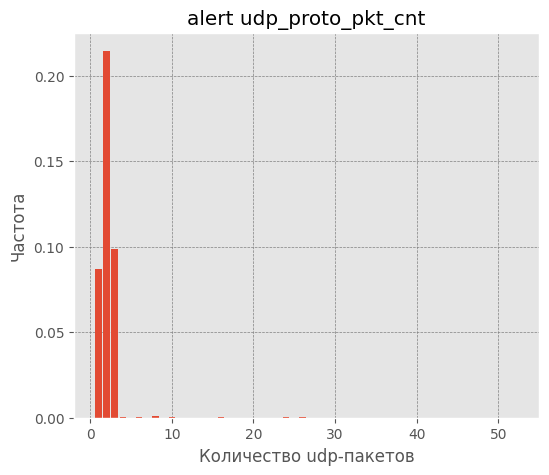

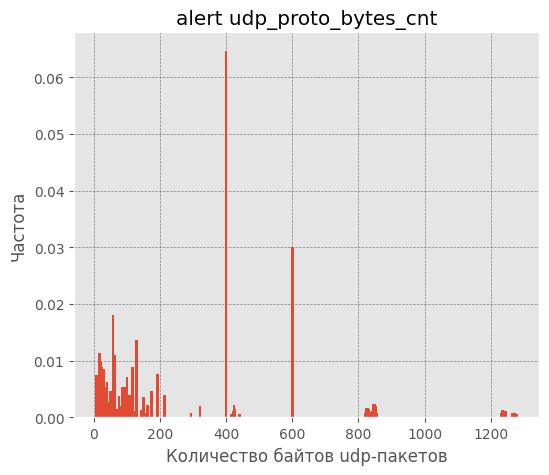

In [54]:
freq_udp_proto_pkt_cnt = alert_flows[
    ['_merge', 'udp_proto_pkt_cnt', 'is_alert']
].groupby(
    'udp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_udp_proto_bytes_cnt = alert_flows[
    ['_merge', 'udp_proto_bytes_cnt', 'is_alert']
].groupby(
    'udp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_udp_proto_pkt_cnt = freq_udp_proto_pkt_cnt.index[1:20]
index_udp_proto_bytes_cnt = freq_udp_proto_bytes_cnt.index[1:100]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert udp_proto_pkt_cnt")
ax1.set_xlabel("Количество udp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index_udp_proto_pkt_cnt, 
        freq_udp_proto_pkt_cnt.loc[index_udp_proto_pkt_cnt]._merge / max(freq_udp_proto_pkt_cnt._merge),
        width=0.8
)
fig1.savefig('pic/_udp_proto_pkt_cnt_alert_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("alert udp_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов udp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_udp_proto_bytes_cnt, 
        freq_udp_proto_bytes_cnt.loc[index_udp_proto_bytes_cnt]._merge / max(freq_udp_proto_bytes_cnt._merge),
        width=8
)
fig2.savefig('pic/_udp_proto_bytes_cnt_alert_hist.png')

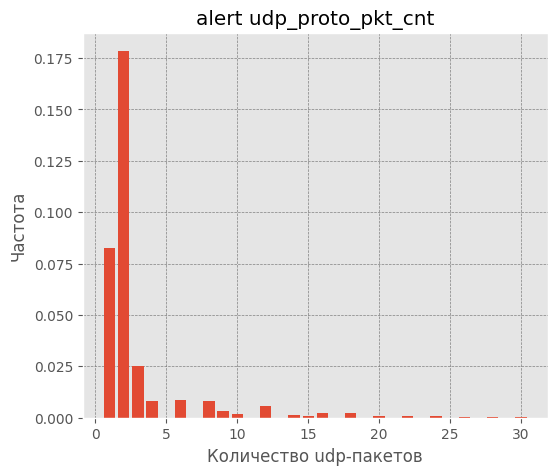

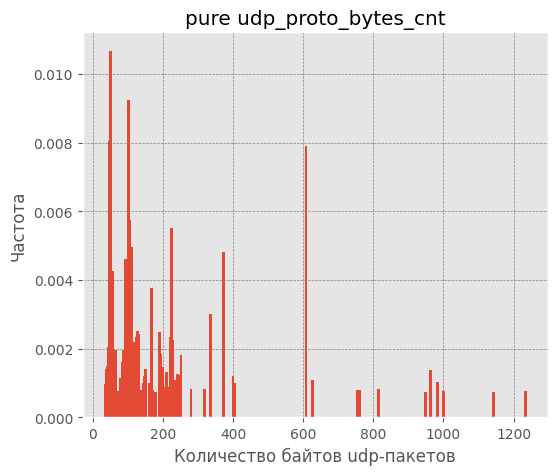

In [55]:
freq_udp_proto_pkt_cnt = pure_flows[
    ['_merge', 'udp_proto_pkt_cnt', 'is_alert']
].groupby(
    'udp_proto_pkt_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)
freq_udp_proto_bytes_cnt = pure_flows[
    ['_merge', 'udp_proto_bytes_cnt', 'is_alert']
].groupby(
    'udp_proto_bytes_cnt'
).count(
).sort_values(
    '_merge',
    ascending=0
)

index_udp_proto_pkt_cnt = freq_udp_proto_pkt_cnt.index[1:20]
index_udp_proto_bytes_cnt = freq_udp_proto_bytes_cnt.index[1:100]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,5)
ax1.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax1.set_title("alert udp_proto_pkt_cnt")
ax1.set_xlabel("Количество udp-пакетов")
ax1.set_ylabel("Частота")
ax1.bar(index_udp_proto_pkt_cnt, 
        freq_udp_proto_pkt_cnt.loc[index_udp_proto_pkt_cnt]._merge / max(freq_udp_proto_pkt_cnt._merge),
        width=0.8
)
fig1.savefig('pic/_udp_proto_pkt_cnt_pure_hist.png')


fig2, ax2 = plt.subplots()
fig2.set_size_inches(6,5)
ax2.grid(True, color='grey', linestyle='--', linewidth=0.5)
ax2.set_title("pure udp_proto_bytes_cnt")
ax2.set_xlabel("Количество байтов udp-пакетов")
ax2.set_ylabel("Частота")
ax2.bar(index_udp_proto_bytes_cnt, 
        freq_udp_proto_bytes_cnt.loc[index_udp_proto_bytes_cnt]._merge / max(freq_udp_proto_bytes_cnt._merge),
        width=8
)
fig2.savefig('pic/_udp_proto_bytes_cnt_pure_hist.png')

## Feature importance

In [20]:
sample_size = 350
sample_list = flows_list[:sample_size]
test_list = flows_list[sample_size:]

In [11]:
disbalance = 49

In [12]:
balanced_batches = []
batch_size = 50
print("start...", end='')
for batch_count in range(len(sample_list) // batch_size):
    print(f"\rbatch n. {batch_count} initialization...", end='')
    batch = pd.concat(
        [
            pd.concat(
                [
                    pd.read_csv(
                        f"dataset/netflow/flow/{filename}", 
                        names=netflow_fields,  
                        encoding="cp1251"
                    ) for filename in sample_list[s:s+5]
                ],
                ignore_index=True
            ).merge(
                alert_data, 
                how='left', 
                on=ident_features,
                indicator=True
            ) [pkt_features + timestamp_features + ['_merge']] 
            for s in range(batch_size * (batch_count)   ,
                           batch_size * (batch_count + 1), 5)
        ],
        ignore_index=True
    )
    batch['is_alert'] = batch['_merge'].replace(
        {
            'both': 1, 'left_only': 0, 'right_only': 0
        },
    )
    batch = batch[
        (
            (
                batch.is_alert == 1
            ) & (
                batch.first_alert_time_sec >= batch.first_pkt_time_sec
            ) & (
                batch.first_alert_time_sec <= batch.last_pkt_time_sec
            ) & (
                batch.last_alert_time_sec <= batch.last_pkt_time_sec
            )
        ) | (
            batch.is_alert == 0
        )
    ][pkt_features + ['is_alert']].drop_duplicates()
    
    alert_index = batch[batch.is_alert == 1].index

    balanced_batch_index = np.concatenate(
        [
            np.random.choice(
                batch[batch.is_alert == 0].index, 
                size=alert_index.shape[0] * disbalance,
                replace=False
            ), 
            alert_index
        ], 
        axis=0
    )
    balanced_batches.append(batch.loc[balanced_batch_index])

batch n. 3 initialization...

In [13]:
X = pd.concat(
    balanced_batches,
    sort=False,
    ignore_index=True
).drop_duplicates()

y = X['is_alert']
X = X[pkt_features]
X.shape

(1662550, 36)

In [14]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=30,
    learning_rate=0.1,
    subsample=0.8,
    n_jobs=-1,
    verbosity=2
)

In [15]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1
)

In [16]:
rf.fit(X, y)

RandomForestClassifier(n_jobs=-1)

In [17]:
xgb.fit(X, y)

[09:37:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2152 extra nodes, 0 pruned nodes, max_depth=30
[09:37:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1934 extra nodes, 0 pruned nodes, max_depth=30
[09:37:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2062 extra nodes, 0 pruned nodes, max_depth=30
[09:37:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2134 extra nodes, 0 pruned nodes, max_depth=30
[09:37:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2630 extra nodes, 0 pruned nodes, max_depth=30
[09:37:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2662 extra nodes, 0 pruned nodes, max_depth=30
[09:37:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 3016 extra nodes, 0 pruned nodes, max_depth=30
[09:37:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 3418 extra nodes, 0 pruned nodes, max_depth=30
[09:37:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 3674 extra n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

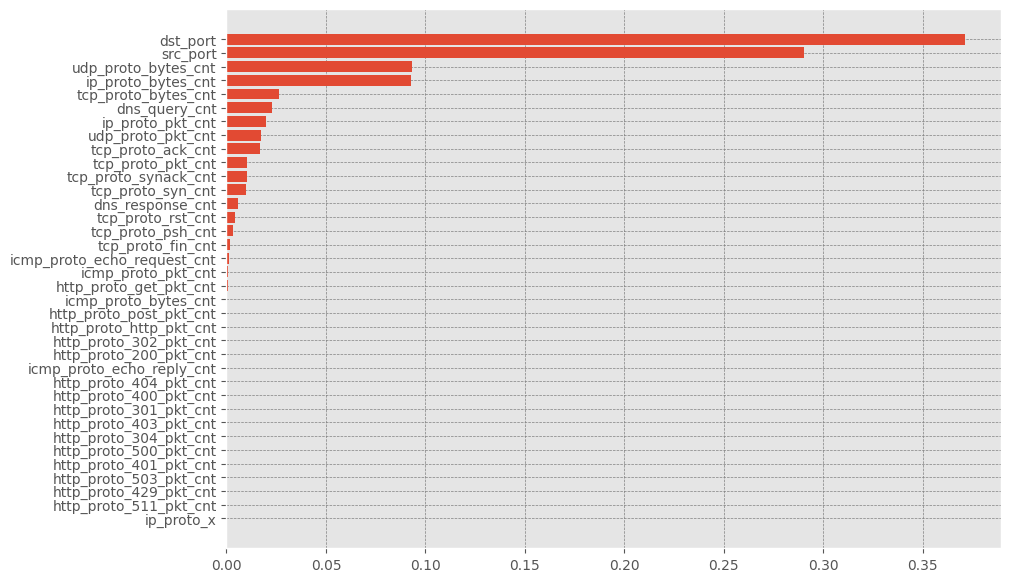

In [18]:
importance = df = pd.DataFrame(
    index=X.columns,
    data=rf.feature_importances_
).sort_values(by=0, ascending=True)

plt.figure(figsize=(10, 7))
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.barh(importance.index, importance[0])
plt.savefig('pic/feature_importances_rf.png')

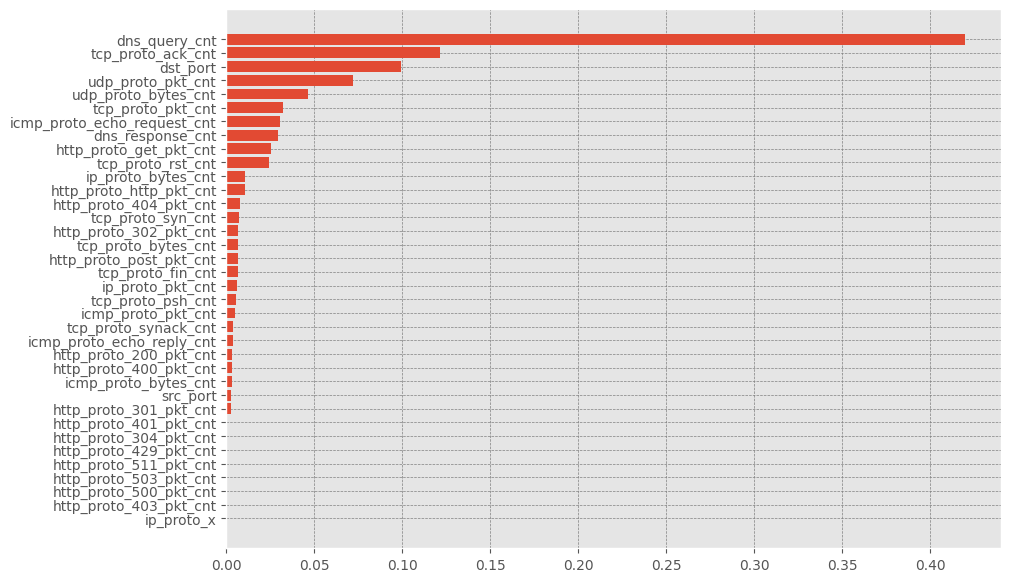

In [19]:
importance = df = pd.DataFrame(
    index=X.columns,
    data=xgb.feature_importances_
).sort_values(by=0, ascending=True)

plt.figure(figsize=(10, 7))
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
plt.barh(importance.index, importance[0])
plt.savefig('pic/feature_importances_xgb.png')